## DRL_single_stock_trading

## Clone code from ggColab_DRL_single_stock_trading_OK.ipynb

In [ ]:
!pip uninstall -y tensorflow==2.6.0
!pip install yfinance
!pip install pandas
!pip install matplotlib
!pip install stockstats
!pip install gym
!pip install stable-baselines[mpi]
!pip install tensorflow==1.15.4

In [ ]:
'''
import pkg_resources
import pip
installedPackages = {pkg.key for pkg in pkg_resources.working_set}
required = {'yfinance', 'pandas', 'matplotlib', 'stockstats','stable-baselines','gym','tensorflow'}
missing = required - installedPackages
if missing:
    !pip install yfinance
    !pip install pandas
    !pip install matplotlib
    !pip install stockstats
    !pip install gym
    !pip install stable-baselines[mpi]
    !pip install tensorflow==1.15.4
'''

In [ ]:
'''
!pip install yfinance
!pip install pandas
!pip install matplotlib
!pip install stockstats
!pip install gym
!pip install stable-baselines[mpi]
!pip install tensorflow==1.15.4
'''

In [1]:
import tensorflow as tf
tf.__version__

'1.15.4'

In [2]:
!git clone https://github.com/pqmsoft1/FinRL_single.git

Cloning into 'FinRL_single'...
remote: Enumerating objects: 117, done.
remote: Counting objects: 100% (117/117), done.
remote: Compressing objects: 100% (99/99), done.
remote: Total 117 (delta 33), reused 92 (delta 13), pack-reused 0
Receiving objects: 100% (117/117), 8.05 MiB | 16.99 MiB/s, done.
Resolving deltas: 100% (33/33), done.


In [3]:
!cd FinRL_single/

In [4]:
!ls

FinRL_single  sample_data


In [ ]:
import yfinance as yf
from stockstats import StockDataFrame as Sdf

import pandas as pd
import matplotlib.pyplot as plt

import gym
from stable_baselines import PPO2, DDPG, A2C, ACKTR, TD3, TRPO 
from stable_baselines import DDPG
from stable_baselines import A2C
from stable_baselines import SAC
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines.common.policies import MlpPolicy



#Diable the warnings
import warnings
warnings.filterwarnings('ignore')


#stockerID = "AMZN"
#stockerID = "MSFT"
#stockerID = "TSLA"
#stockerID ="FDX"
#stockerID ="ABMD"
#stockerID ="ABT"
#stockerID = "AAP"
#stockerID = "ABBV"
#stockerID = "AAPL"

'''
#ABBV OK
# TD3
stockerID = "ABBV"
START_DATE_DATA = "2009-01-01"
END_DATE_TRAIN_DATA = "2020-01-01"
END_DATE_DATA = "2021-01-01"

'''


'''
#OK
# TD3
stockerID = "AAPL"
START_DATE_DATA = "2009-01-01"
END_DATE_TRAIN_DATA = "2020-09-01"
END_DATE_DATA = "2021-09-01"
'''



'''

START_DATE_DATA = "2010-01-01"
END_DATE_TRAIN_DATA = "2020-01-01"
END_DATE_DATA = "2021-09-01"
'''

'''
#OK
# TD3
stockerID = "MSFT"
START_DATE_DATA = "2015-01-01"
END_DATE_TRAIN_DATA = "2020-01-01"
END_DATE_DATA = "2021-09-01"
'''

'''
#OK
# TD3
stockerID = "MSFT"
START_DATE_DATA = "2010-01-01"
END_DATE_TRAIN_DATA = "2021-01-01"
END_DATE_DATA = "2021-09-20"

'''

'''
#OK
# TD3
stockerID = "ABBV"
START_DATE_DATA = "2010-01-01"
END_DATE_TRAIN_DATA = "2021-01-01"
END_DATE_DATA = "2021-09-20"

'''


stockerID = "ABBV"
START_DATE_DATA = "2010-01-01"
END_DATE_TRAIN_DATA = "2021-01-01"

END_DATE_DATA = "2021-09-20"

#======================================================== A2C/PPO ==============================================
'''
# A2C/PPO
stockerID = "AMZN"
START_DATE_DATA = "2009-01-01"
END_DATE_TRAIN_DATA = "2021-01-01"
END_DATE_DATA = "2021-09-20"
'''


PATH_CSV_STOCK = stockerID + ".csv"

data_df = yf.download(stockerID, start=START_DATE_DATA, end=END_DATE_DATA)
# reset the index, we want to use numbers instead of dates
data_df=data_df.reset_index()
# convert the column names to standardized names
data_df.columns = ['datadate','open','high','low','close','adjcp','volume']
# save the data to a csv file in your current folder
#data_df.to_csv('AAPL_2009_2020.csv')
#data_df.to_csv('FB_2009_2021.csv')
data_df.to_csv(PATH_CSV_STOCK)
# check missing data 
data_df.isnull().values.any()
# calculate technical indicators like MACD
stock = Sdf.retype(data_df.copy())
# we need to use adjusted close price instead of close price
stock['close'] = stock['adjcp']
data_df['macd'] = stock['macd']
# check missing data again
data_df.isnull().values.any()
# Note that I always use a copy of the original data to try it track step by step.
data_clean = data_df.copy()


import numpy as np
import pandas as pd
from gym.utils import seeding
import gym
from gym import spaces
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

# Global variables
HMAX_NORMALIZE = 200
INITIAL_ACCOUNT_BALANCE=100000
#INITIAL_ACCOUNT_BALANCE=10000
STOCK_DIM = 1

# transaction fee: 1/1000 reasonable percentage
TRANSACTION_FEE_PERCENT = 0.001
# REWARD_SCALING = 1e-3


class SingleStockEnv(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}

    def __init__(self, df,day = 0):
        #super(StockEnv, self).__init__()
        # date increment
        self.day = day
        self.df = df
        # action_space normalization and the shape is STOCK_DIM
        self.action_space = spaces.Box(low = -1, high = 1,shape = (STOCK_DIM,)) 
        # Shape = 4: [Current Balance]+[prices]+[owned shares] +[macd] 
        self.observation_space = spaces.Box(low=0, high=np.inf, shape = (4,))
        # load data from a pandas dataframe
        self.data = self.df.loc[self.day,:]
        # termination
        self.terminal = False  
        # save the total number of trades
        self.trades = 0
        # initalize state
        self.state = [INITIAL_ACCOUNT_BALANCE] + \
                      [self.data.adjcp] + \
                      [0]*STOCK_DIM + \
                      [self.data.macd] 
        # initialize reward and cost
        self.reward = 0
        self.cost = 0
        
        # memorize the total value, total rewards
        self.asset_memory = [INITIAL_ACCOUNT_BALANCE]
        self.rewards_memory = []

    def _sell_stock(self, index, action):
        # perform sell action based on the sign of the action
        if self.state[index+STOCK_DIM+1] > 0:
            # update balance
            self.state[0] += \
            self.state[index+1]*min(abs(action),self.state[index+STOCK_DIM+1]) * \
             (1- TRANSACTION_FEE_PERCENT)
            # update held shares
            self.state[index+STOCK_DIM+1] -= min(abs(action), self.state[index+STOCK_DIM+1])
            # update transaction costs
            self.cost +=self.state[index+1]*min(abs(action),self.state[index+STOCK_DIM+1]) * \
             TRANSACTION_FEE_PERCENT
            self.trades+=1
        else:
            pass
            
    def _buy_stock(self, index, action):
        # perform buy action based on the sign of the action
        available_amount = self.state[0] // self.state[index+1]
        #update balance
        self.state[0] -= self.state[index+1]*min(available_amount, action)* \
                          (1+ TRANSACTION_FEE_PERCENT)
        # update held shares
        self.state[index+STOCK_DIM+1] += min(available_amount, action)
        # update transaction costs
        self.cost+=self.state[index+1]*min(available_amount, action)* \
                          TRANSACTION_FEE_PERCENT
        self.trades+=1
        
    def step(self, actions):
        self.terminal = self.day >= len(self.df.index.unique())-1
        #print(self.day)
        #print(self.df.index.unique())
        #print(len(self.df.index.unique())-1)
        if self.terminal:
            
            plt.plot(self.asset_memory,'r')
            plt.savefig('account_value.png')
            plt.close()
            
            end_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            print("previous_total_asset:{}".format(self.asset_memory[0])) 
            print("end_total_asset:{}".format(end_total_asset))
            
            df_total_value = pd.DataFrame(self.asset_memory)
            df_total_value.to_csv('account_value.csv')
            print("total_reward:{}".format(self.state[0]+sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))- INITIAL_ACCOUNT_BALANCE ))
            print("total_cost: ", self.cost)
            print("total trades: ", self.trades)
            
            df_total_value.columns = ['account_value']
            df_total_value['daily_return']=df_total_value.pct_change(1)
            
            if df_total_value['daily_return'].std()!=0:
                sharpe = (252**0.5)*df_total_value['daily_return'].mean()/ \
                      df_total_value['daily_return'].std()
                print("Sharpe: ",sharpe)
            df_rewards = pd.DataFrame(self.rewards_memory)
            df_rewards.to_csv('account_rewards.csv')
            return self.state, self.reward, self.terminal,{}

        else:

            # actions are the shares we need to buy, hold, or sell
            actions = actions * HMAX_NORMALIZE
            # calculate begining total asset
            begin_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            
            # perform buy or sell action
            argsort_actions = np.argsort(actions)
            sell_index = argsort_actions[:np.where(actions < 0)[0].shape[0]]
            buy_index = argsort_actions[::-1][:np.where(actions > 0)[0].shape[0]]

            for index in sell_index:
                # print('take sell action'.format(actions[index]))
                self._sell_stock(index, actions[index])

            for index in buy_index:
                # print('take buy action: {}'.format(actions[index]))
                self._buy_stock(index, actions[index])
            
            # update data, walk a step s'
            self.day += 1
            self.data = self.df.loc[self.day,:]         
            #load next state
            self.state =  [self.state[0]] + \
                          [self.data.adjcp] + \
                          list(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]) +\
                          [self.data.macd]
                        
            # calculate the end total asset
            end_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            self.reward = end_total_asset - begin_total_asset  
            self.rewards_memory.append(self.reward)
            #self.reward = self.reward * REWARD_SCALING
            self.asset_memory.append(end_total_asset)

        return self.state, self.reward, self.terminal, {}

    def reset(self):
        self.asset_memory = [INITIAL_ACCOUNT_BALANCE]
        self.day = 0
        self.data = self.df.loc[self.day,:]
        self.cost = 0
        self.trades = 0
        self.terminal = False 
        self.rewards_memory = []
        #initiate state
        self.state = [INITIAL_ACCOUNT_BALANCE] + \
                      [self.data.adjcp] + \
                      [0]*STOCK_DIM + \
                      [self.data.macd]
        return self.state
    
    def render(self, mode='human'):
        return self.state

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]


train = data_clean[(data_clean.datadate>=START_DATE_DATA) & (data_clean.datadate < END_DATE_TRAIN_DATA)]
# the index needs to start from 0
train=train.reset_index(drop=True)

## Model Training: 4 models, PPO A2C, DDPG, TD3


'''
#===================================== ppo =====================================

## Model 1: PPO

#tensorboard --logdir ./single_stock_tensorboard/
env_train = DummyVecEnv([lambda: SingleStockEnv(train)])
model_ppo = PPO2('MlpPolicy', env_train, tensorboard_log="./single_stock_trading_2_tensorboard/")
model_ppo.learn(total_timesteps=100000,tb_log_name="run_aapl_ppo")
#model_ppo.save('AAPL_ppo_100k')
#model_ppo.save('AAPL_ppo_100k')
#model_sticker_save = 'FB_ppo_100k'
model_sticker_save = model_sticker_save = stockerID + '_PPO_100k'
model_ppo.save(model_sticker_save)



env_train = DummyVecEnv([lambda: SingleStockEnv(train)])
model_ppo = PPO2('MlpPolicy', env_train, tensorboard_log="./single_stock_trading_2_tensorboard/")
#model_ppo.load('AAPL_ppo_100k.zip')
model_ppo.load(model_sticker_save)
model = model_ppo

#===================================== ppo =====================================
'''

#===================================== A2C =====================================

## Model 1: A2C

#tensorboard --logdir ./single_stock_tensorboard/
env_train = DummyVecEnv([lambda: SingleStockEnv(train)])
model_a2c = A2C('MlpPolicy', env_train, tensorboard_log="./single_stock_trading_2_tensorboard/")
#model_a2c.learn(total_timesteps=100000,tb_log_name="run_aapl_a2c")
model_a2c.learn(total_timesteps=2000000,tb_log_name="run_aapl_a2c")

model_sticker_save = model_sticker_save = stockerID + '_PPO_100k'
model_a2c.save(model_sticker_save)


env_train = DummyVecEnv([lambda: SingleStockEnv(train)])
model_a2c = A2C('MlpPolicy', env_train, tensorboard_log="./single_stock_trading_2_tensorboard/")
model_a2c.load(model_sticker_save)

model = model_a2c


#===================================== A2C =====================================



'''
#===================================== TD3 =====================================

model_sticker_save = stockerID + '_TD3_100k'


#tensorboard --logdir ./single_stock_tensorboard/
#DQN<DDPG<TD3
env_train = DummyVecEnv([lambda: SingleStockEnv(train)])
model_td3 = TD3('MlpPolicy', env_train, tensorboard_log="./single_stock_trading_2_tensorboard/")
#model_td3.learn(total_timesteps=100000,tb_log_name="run_aapl_td3")
#model_td3.save('AAPL_td3_50k')
#model_td3.learn(total_timesteps=100000,tb_log_name="run_aapl_td3")
model_td3.learn(total_timesteps=200000,tb_log_name="run_aapl_td3")



#model_td3.save('AAPL_td3_50k')
model_td3.save(model_sticker_save)


env_train = DummyVecEnv([lambda: SingleStockEnv(train)])
model_td3 = TD3('MlpPolicy', env_train, tensorboard_log="./single_stock_trading_2_tensorboard/")
#model_td3.load('AAPL_td3_50k.zip')

model_td3.load(model_sticker_save)
model = model_td3

#===================================== TD3 =====================================
'''
'''
#==================================== SAC ======================================



model_sticker_save = stockerID + '_SAC_100k'


#tensorboard --logdir ./single_stock_tensorboard/
#DQN<DDPG<TD3
env_train = DummyVecEnv([lambda: SingleStockEnv(train)])
model_sac = SAC('MlpPolicy', env_train, tensorboard_log="./single_stock_trading_2_tensorboard/")
#model_td3.learn(total_timesteps=100000,tb_log_name="run_aapl_td3")
#model_td3.save('AAPL_td3_50k')
#model_td3.learn(total_timesteps=100000,tb_log_name="run_aapl_td3")
model_sac.learn(total_timesteps=100000,tb_log_name="run_aapl_td3")



#model_td3.save('AAPL_td3_50k')
model_sac.save(model_sticker_save)


env_train = DummyVecEnv([lambda: SingleStockEnv(train)])
model_sac = SAC('MlpPolicy', env_train, tensorboard_log="./single_stock_trading_2_tensorboard/")
#model_td3.load('AAPL_td3_50k.zip')

model_sac.load(model_sticker_save)
model = model_sac


#==================================== SAC ======================================


'''
'''
#==================================== ACKTR ======================================



model_sticker_save = stockerID + '_ACKTR_100k'


#tensorboard --logdir ./single_stock_tensorboard/
#DQN<DDPG<TD3
env_train = DummyVecEnv([lambda: SingleStockEnv(train)])
model_ACKTR = ACKTR('MlpPolicy', env_train, tensorboard_log="./single_stock_trading_2_tensorboard/")
#model_td3.learn(total_timesteps=100000,tb_log_name="run_aapl_td3")
#model_td3.save('AAPL_td3_50k')
#model_td3.learn(total_timesteps=100000,tb_log_name="run_aapl_td3")
model_ACKTR.learn(total_timesteps=100000,tb_log_name="run_aapl_ACKTR")



#model_td3.save('AAPL_td3_50k')
model_ACKTR.save(model_sticker_save)


env_train = DummyVecEnv([lambda: SingleStockEnv(train)])
model_ACKTR = ACKTR('MlpPolicy', env_train, tensorboard_log="./single_stock_trading_2_tensorboard/")
#model_td3.load('AAPL_td3_50k.zip')

model_ACKTR.load(model_sticker_save)
model = model_ACKTR


#==================================== ACKTR ======================================
'''


'''
#TRPO
#==================================== TRPO ======================================



model_sticker_save = stockerID + '_TRPO_100k'


#tensorboard --logdir ./single_stock_tensorboard/
#DQN<DDPG<TD3
env_train = DummyVecEnv([lambda: SingleStockEnv(train)])
model_TRPO = TRPO('MlpPolicy', env_train, tensorboard_log="./single_stock_trading_2_tensorboard/")

model_TRPO.learn(total_timesteps=200000,tb_log_name="run_aapl_TRPO")



#model_td3.save('AAPL_td3_50k')
model_TRPO.save(model_sticker_save)


env_train = DummyVecEnv([lambda: SingleStockEnv(train)])
model_TRPO = TRPO('MlpPolicy', env_train, tensorboard_log="./single_stock_trading_2_tensorboard/")
#model_td3.load('AAPL_td3_50k.zip')

model_TRPO.load(model_sticker_save)
model = model_TRPO


#==================================== TRPO ======================================
'''

'''
#===================================== DDPG =====================================
model_sticker_save = stockerID + '_DDPG_100k'


#tensorboard --logdir ./single_stock_tensorboard/
env_train = DummyVecEnv([lambda: SingleStockEnv(train)])
model_ddpg = DDPG('MlpPolicy', env_train, tensorboard_log="./single_stock_trading_2_tensorboard/")
model_ddpg.learn(total_timesteps=100000, tb_log_name="run_aapl_ddpg")

model_ddpg.save(model_sticker_save)


env_train = DummyVecEnv([lambda: SingleStockEnv(train)])
model_ddpg = DDPG('MlpPolicy', env_train, tensorboard_log="./single_stock_trading_2_tensorboard/")
model_ddpg.load(model_sticker_save)

model = model_ddpg

#===================================== DDPG =====================================
'''

'''

#==================================== A3C ======================================


model_sticker_save = stockerID + '_A3C_100k'


#tensorboard --logdir ./single_stock_tensorboard/
#DQN<DDPG<TD3
env_train = DummyVecEnv([lambda: SingleStockEnv(train)])
model_A3C = A3C('MlpPolicy', env_train, tensorboard_log="./single_stock_trading_2_tensorboard/")

model_A3C.learn(total_timesteps=200000,tb_log_name="run_aapl_A3C")

model_A3C.save(model_sticker_save)


env_train = DummyVecEnv([lambda: SingleStockEnv(train)])
model_A3C = A3C('MlpPolicy', env_train, tensorboard_log="./single_stock_trading_2_tensorboard/")
#model_td3.load('AAPL_td3_50k.zip')

model_A3C.load(model_sticker_save)
model = model_A3C


#==================================== A3C ======================================
'''


[*********************100%***********************]  1 of 1 completed

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
previous_total_asset:100000
end_total_asset:152036.4894984792
total_reward:52036.489498479204
total_cost:  13813.697273473652
total trades:  1988
Sharpe:  0.412319781746158
previous_total_asset:100000
end_total_asset:274652.25147618674
total_reward:174652.25147618674
total_cost:  11636.49652235853
total trades:  2009
Sharpe:  0.6213971881679807
previous_total_asset:100000
end_total_asset:279515.8963054148
total_reward:179515.8963054148
total_cost:  13434.071877367005
total trades:  2009
Sharpe:  0.6584824209567095
previous_total_asset:100000
end_total_asset:310591.2828006319
total_reward:210591.2828006319
total_cost:  13616.582019007945
total trades:  2013
Sharpe:  0.6862586927366278
previous_total_asset:100000
end_total_asset:369807.8298548205
total_reward:269807.8298548205
total_cost:  11536.6740425

==============Model Prediction===========
previous_total_asset:100000
end_total_asset:106623.463471806
total_reward:6623.463471805997
total_cost:  1944.0581485782516
total trades:  174
Sharpe:  0.8044334390694318
annual return:  10.322730424550919
sharpe ratio:  0.804433439069411
annual return:  10.766287942698426
sharpe ratio:  0.4876153641555982


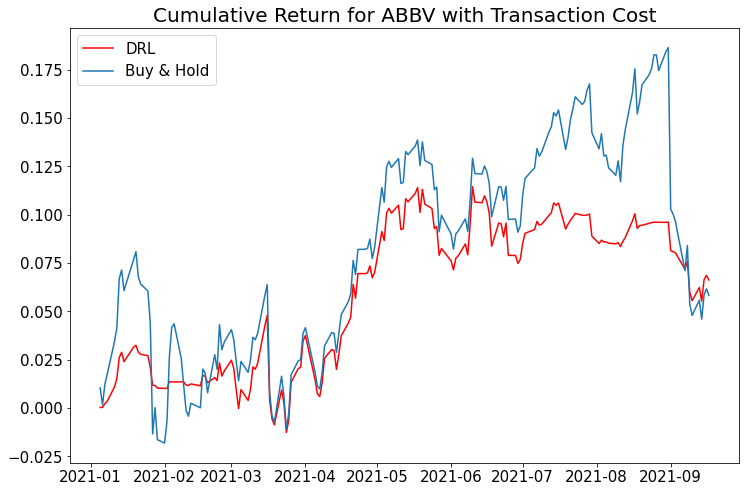

In [34]:
#====================================================PREDICT=================================================
# Trading
# Assume that we have $100,000 initial capital at 2019-01-01. We use the TD3 model to trade AAPL.
## sau khi chay xong: create file account_rewards.csv, account_value.csv, account_value.png 


test = data_clean[(data_clean.datadate >= END_DATE_TRAIN_DATA) ]
# the index needs to start from 0
test=test.reset_index(drop=True)


#model = model_a2c
#model = model_ppo
#model = model_td3



env_test = DummyVecEnv([lambda: SingleStockEnv(test)])
obs_test = env_test.reset()
print("==============Model Prediction===========")
for i in range(len(test.index.unique())):
    action, _states = model.predict(obs_test)
    obs_test, rewards, dones, info = env_test.step(action)
    env_test.render()

#==> Create file account_rewards.csv, account_value.csv, account_value.png sau khi chay xong


'''
Part 5: Backtest Our Strategy
For simplicity purposes, in the article, we just calculate the Sharpe ratio and the annual return manually.
'''


def get_DRL_sharpe():
    df_total_value=pd.read_csv('account_value.csv',index_col=0)
    df_total_value.columns = ['account_value']
    df_total_value['daily_return']=df_total_value.pct_change(1)
    sharpe = (252**0.5)*df_total_value['daily_return'].mean()/ \
    df_total_value['daily_return'].std()
    
    annual_return = ((df_total_value['daily_return'].mean()+1)**252-1)*100
    print("annual return: ", annual_return)
    print("sharpe ratio: ", sharpe)
    return df_total_value


def get_buy_and_hold_sharpe(test):
    test['daily_return']=test['adjcp'].pct_change(1)
    sharpe = (252**0.5)*test['daily_return'].mean()/ \
    test['daily_return'].std()
    annual_return = ((test['daily_return'].mean()+1)**252-1)*100
    print("annual return: ", annual_return)

    print("sharpe ratio: ", sharpe)
    #return sharpe

df_total_value=get_DRL_sharpe()
get_buy_and_hold_sharpe(test)
DRL_cumulative_return = (df_total_value.account_value.pct_change(1)+1).cumprod()-1
buy_and_hold_cumulative_return = (test.adjcp.pct_change(1)+1).cumprod()-1



%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 8))

plt.plot(test.datadate, DRL_cumulative_return, color='red',label = "DRL")
plt.plot(test.datadate, buy_and_hold_cumulative_return, label = "Buy & Hold")
titleTmp = "Cumulative Return for " + stockerID + " with Transaction Cost" 
plt.title(titleTmp,size= 20)
plt.legend()
plt.rc('legend',fontsize=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)


[*********************100%***********************]  1 of 1 completed


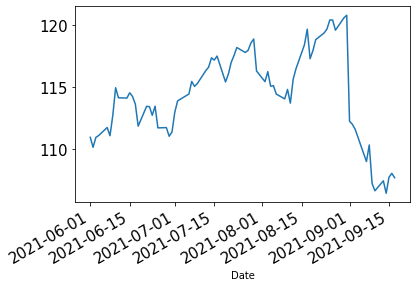

In [ ]:
# Import yfinance package
import yfinance as yf

# Import matplotlib for plotting
import matplotlib.pyplot as plt
%matplotlib inline

start_date = END_DATE_TRAIN_DATA
end_date = END_DATE_DATA

# Set the ticker
#ticker = 'AMZN'
ticker = stockerID


# Get the data
data = yf.download(ticker, start_date, end_date)

# Print 5 rows
#data.tail()

# Plot adjusted close price data
data['Adj Close'].plot()
plt.show()



## Model Training: 4 models, PPO A2C, DDPG, TD3
## Model 1: PPO

In [ ]:
#tensorboard --logdir ./single_stock_tensorboard/
env_train = DummyVecEnv([lambda: SingleStockEnv(train)])
model_ppo = PPO2('MlpPolicy', env_train, tensorboard_log="./single_stock_trading_2_tensorboard/")
model_ppo.learn(total_timesteps=100000,tb_log_name="run_aapl_ppo")
#model_ppo.save('AAPL_ppo_100k')
#model_ppo.save('AAPL_ppo_100k')
#model_sticker_save = 'FB_ppo_100k'
model_sticker_save = 'amzn_ppo_100k'
model_ppo.save(model_sticker_save)

## Model 2: DDPG

In [ ]:
#tensorboard --logdir ./single_stock_tensorboard/
env_train = DummyVecEnv([lambda: SingleStockEnv(train)])
model_ddpg = DDPG('MlpPolicy', env_train, tensorboard_log="./single_stock_trading_2_tensorboard/")
model_ddpg.learn(total_timesteps=100000, tb_log_name="run_aapl_ddpg")
#model_ddpg.save('AAPL_ddpg_50k')

In [ ]:
#model_ddpg.learn(total_timesteps=100000, tb_log_name="run_aapl_ddpg")
model_ddpg.save('AAPL_ddpg_50k')

#model_ddpg.save(model_sticker_save)


## Model 3: A2C

In [ ]:
#tensorboard --logdir ./single_stock_tensorboard/
env_train = DummyVecEnv([lambda: SingleStockEnv(train)])
model_a2c = A2C('MlpPolicy', env_train, tensorboard_log="./single_stock_trading_2_tensorboard/")
model_a2c.learn(total_timesteps=100000,tb_log_name="run_aapl_a2c")
#model_a2c.save('AAPL_a2c_50k')

In [ ]:
model_a2c.save('AAPL_a2c_50k')
#model_a2c.save(model_sticker_save)

## Model 4: TD3

In [ ]:
#tensorboard --logdir ./single_stock_tensorboard/
#DQN<DDPG<TD3
env_train = DummyVecEnv([lambda: SingleStockEnv(train)])
model_td3 = TD3('MlpPolicy', env_train, tensorboard_log="./single_stock_trading_2_tensorboard/")
#model_td3.learn(total_timesteps=100000,tb_log_name="run_aapl_td3")
#model_td3.save('AAPL_td3_50k')
model_td3.learn(total_timesteps=100000,tb_log_name="run_aapl_td3")
model_td3.save('AAPL_td3_50k')
#model_td3.save(model_sticker_save)


## Testing data

## Load model from file save

## Load model PPO

In [ ]:
env_train = DummyVecEnv([lambda: SingleStockEnv(train)])
model_ppo = PPO2('MlpPolicy', env_train, tensorboard_log="./single_stock_trading_2_tensorboard/")
#model_ppo.load('AAPL_ppo_100k.zip')
model_ppo.load(model_sticker_save)


## Load models a2c

In [ ]:
env_train = DummyVecEnv([lambda: SingleStockEnv(train)])
model_a2c = A2C('MlpPolicy', env_train, tensorboard_log="./single_stock_trading_2_tensorboard/")
model_a2c.load(model_sticker_save)

## Load model ddpg

In [ ]:
env_train = DummyVecEnv([lambda: SingleStockEnv(train)])
model_ddpg = DDPG('MlpPolicy', env_train, tensorboard_log="./single_stock_trading_2_tensorboard/")
#model_ddpg.load('AAPL_ddpg_50k.zip')
model_ddpg.load(model_sticker_save)



## Load model td3

In [ ]:
env_train = DummyVecEnv([lambda: SingleStockEnv(train)])
model_td3 = TD3('MlpPolicy', env_train, tensorboard_log="./single_stock_trading_2_tensorboard/")
model_td3.load('AAPL_td3_50k.zip')


# Trading
Assume that we have $100,000 initial capital at 2019-01-01. We use the TD3 model to trade AAPL.

## sau khi chay xong: create file account_rewards.csv, account_value.csv, account_value.png 

In [ ]:

test = data_clean[(data_clean.datadate >= END_DATE_TRAIN_DATA) ]
# the index needs to start from 0
test=test.reset_index(drop=True)




In [ ]:
test

In [ ]:
#model = model_a2c
model = model_ppo
#model = model_td3
#model = model_ddpg
env_test = DummyVecEnv([lambda: SingleStockEnv(test)])
obs_test = env_test.reset()
print("==============Model Prediction===========")
for i in range(len(test.index.unique())):
    action, _states = model.predict(obs_test)
    obs_test, rewards, dones, info = env_test.step(action)
    env_test.render()

#==> Create file account_rewards.csv, account_value.csv, account_value.png sau khi chay xong

==============Model Prediction===========
previous_total_asset:100000
end_total_asset:91214.80049134279
total_reward:-8785.199508657213
total_cost:  1216.9028415728942
total trades:  52
Sharpe:  -3.1096071839715838


## Part 5: Backtest Our Strategy
For simplicity purposes, in the article, we just calculate the Sharpe ratio and the annual return manually.

In [ ]:

def get_DRL_sharpe():
    df_total_value=pd.read_csv('account_value.csv',index_col=0)
    df_total_value.columns = ['account_value']
    df_total_value['daily_return']=df_total_value.pct_change(1)
    sharpe = (252**0.5)*df_total_value['daily_return'].mean()/ \
    df_total_value['daily_return'].std()
    
    annual_return = ((df_total_value['daily_return'].mean()+1)**252-1)*100
    print("annual return: ", annual_return)
    print("sharpe ratio: ", sharpe)
    return df_total_value


def get_buy_and_hold_sharpe(test):
    test['daily_return']=test['adjcp'].pct_change(1)
    sharpe = (252**0.5)*test['daily_return'].mean()/ \
    test['daily_return'].std()
    annual_return = ((test['daily_return'].mean()+1)**252-1)*100
    print("annual return: ", annual_return)

    print("sharpe ratio: ", sharpe)
    #return sharpe

df_total_value=get_DRL_sharpe()
get_buy_and_hold_sharpe(test)
DRL_cumulative_return = (df_total_value.account_value.pct_change(1)+1).cumprod()-1
buy_and_hold_cumulative_return = (test.adjcp.pct_change(1)+1).cumprod()-1


annual return:  -34.2962179054769
sharpe ratio:  -3.1096071839715633
annual return:  -50.82201630086771
sharpe ratio:  -3.7496910745541077


In [ ]:
#DRL_cumulative_return

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 8))

plt.plot(test.datadate, DRL_cumulative_return, color='red',label = "DRL")
plt.plot(test.datadate, buy_and_hold_cumulative_return, label = "Buy & Hold")
plt.title("Cumulative Return for AAPL with Transaction Cost",size= 20)
plt.legend()
plt.rc('legend',fontsize=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

In [ ]:
from google.colab import files

files.download('AAPL_a2c_50k.zip')
files.download('AAPL_td3_50k.zip')
files.download('AAPL_ppo_100k.zip')
files.download('AAPL_ddpg_50k.zip')